# Comparing Molecules among Molecular Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

#### Load the data

In [2]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './rdKit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)

In [3]:
print(lig_datasets.keys())
lig_datasets['COCRYS'].head(3)

dict_keys(['COCRYS', 'CSAR', 'DUD', 'DEKOIS'])


,Activity,mol_rdk,sanitized,MW,num_atoms
Lig,,,,,
STU,active,<rdkit.Chem.rdchem.Mol object at 0x7ffa3d188af0>,True,465.533,35
ATP,active,<rdkit.Chem.rdchem.Mol object at 0x7ffa3c93cab0>,True,503.150,31
PVB,active,<rdkit.Chem.rdchem.Mol object at 0x7ffa129b37b0>,True,259.700,18


## Using RDKit to evaluate some molecular descriptors

In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']] 

### Plots

In [5]:
# Import some helper functions
from helper_functions_2 import violin_plot_helper, swarm_plot_helper

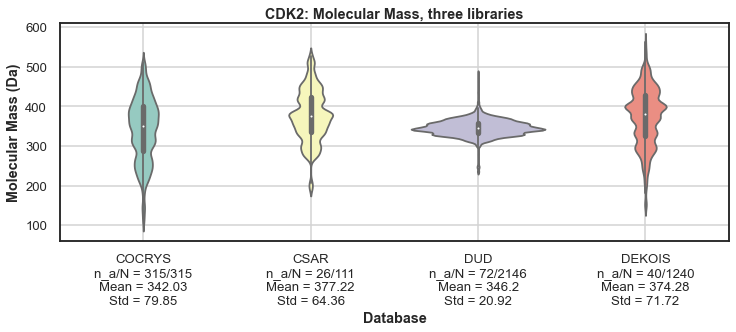

In [6]:
violin_plot_helper('MW', lig_datasets,               
    title = 'CDK2: Molecular Mass, three libraries', palette= 'Set3',
    xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=False)

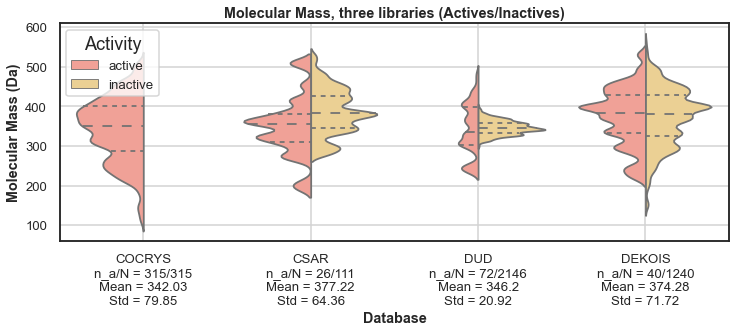

In [7]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=True)

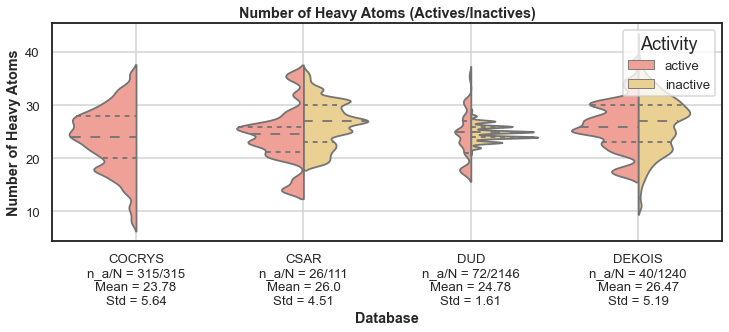

In [8]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split_by_activity=True)

## Merge the data frames (Molecular libraries)

In [9]:
# Get a dataframe for each library 
library_names = lig_datasets.keys()
dfs_list = []

# add a new column
for name in library_names:
    df = lig_datasets[name]
    # Add new column with its name
    df['library'] = name
    # Append to the df list
    dfs_list.append(df)

# Concat
df_all_mols = pd.concat(dfs_list, ignore_index=False).reset_index()
df_all_mols = df_all_mols.rename(columns={'index': 'name'})

In [10]:
## Compute fingerprints

In [11]:
%%time
# compute MACCS Fingerprints
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs

def fps_to_array(fps, drop_constant_cols=True):
    """Convert a list of molecular fingerprints into a 
    numpy m*n array, where n = # molecules and n = # fps"""
    def fp2arr(fp):
        arr = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    X = np.asarray([fp2arr(fp) for fp in fps])
    if drop_constant_cols:
        X = pd.DataFrame(X)
        X = X.loc[:, X.var() != 0.0] 
    return X 


# Maccs Fingerprints
fps_all_maccs = [MACCSkeys.GenMACCSKeys(i) for i in df_all_mols.mol_rdk]
X_all_maccs = fps_to_array(fps_all_maccs)
print("MACCS Fps:", X_all_maccs.shape)
    
# Morgan Fingerprints
fps_all_morgan = [GetMorganFingerprintAsBitVect(i, radius=2) for i in df_all_mols.mol_rdk]
X_all_morgan = fps_to_array(fps_all_morgan)
print("Morgan Fps:", X_all_morgan.shape)

# RDKit Fingerprints
fps_all_rdk = [Chem.RDKFingerprint(i) for i in df_all_mols.mol_rdk]
X_all_rdk = fps_to_array(fps_all_rdk)
print("RDKit Fps:", X_all_rdk.shape)

MACCS Fps: (3812, 147)
Morgan Fps: (3812, 2047)
RDKit Fps: (3812, 2048)
CPU times: user 8.21 s, sys: 327 ms, total: 8.54 s
Wall time: 8.71 s


### Compare Molecules among datasets using MACCS Fingerprints

In [12]:
from helper_functions_2 import draw_matched_ligs, compare_lig_db

In [13]:
from modules.run_or_load_decorator import run_or_load

In [14]:
%%time
from itertools import combinations
from rdkit import DataStructs

'''The following list should have the same order of molecules, i.e., 
the same index should refers to the same molecule info in all list'''

# The following file will save the results
file_matched_mols = './df_repeated_mols_among_CSAR_DUD_DEKIOS_COCRYS.obj'

@run_or_load
def find_redundand_molecules(filename, df):
    indices = df.index.values
    names = df.name.values
    mols = df.mol_rdk.values
    libraries = df.library.values
    fps = fps_all_morgan # We'll use Morgan fingerprints

    matched_molecules = []
    for j, k in sorted(combinations(df_all_mols.index.values, 2), reverse=True):
        fp_sim = DataStructs.FingerprintSimilarity(fps[j], fps[k],
                       metric=DataStructs.TanimotoSimilarity)
        if fp_sim == 1: # If similarity is equal to one
           matched_molecules.append( (names[j], names[k], libraries[j] + '_' + libraries[k],
                                      names[j] + '$' + libraries[j],
                                      names[k] + '$' + libraries[k]))
    # Create a dataframe
    df_matched_mols = pd.DataFrame(matched_molecules, 
                                   columns = ['mol1', 'mol2', 'libraries', 'mol1_lib1', 'mol2_lib2'])
    return df_matched_mols

# ***********************************
# Sort by library and by mol column
# ***********************************
df_matched_mols = find_redundand_molecules(filename=file_matched_mols, df=df_all_mols)
    
# ***********************************
# Sort by library and by mol column
# ***********************************
df_matched_mols.sort_values(['libraries', 'mol1'], inplace=True)

print('Number of repeated molecules among different or the same database:\n', df_matched_mols.shape[0])

File loaded: ./df_repeated_mols_among_CSAR_DUD_DEKIOS_COCRYS.obj
Number of repeated molecules among different or the same database:
 538
CPU times: user 3.66 ms, sys: 3.97 ms, total: 7.63 ms
Wall time: 32.1 ms


#### How many molecules are repeated among a pair  of molecular libraries

In [15]:
#******
# Set of all repeated molecules
#******
unique_repeated_mols = set(df_matched_mols.mol2_lib2.unique().tolist() +  df_matched_mols.mol1_lib1.unique().tolist())

In [16]:
print('There are', df_matched_mols.shape[0], 'pairs of duplicated molecules.', 
      df_matched_mols.shape[0]*2, 'molecules. But some appears more than once')

print(df_matched_mols.mol1.str.contains('^decoy').sum() + 
      df_matched_mols.mol2.str.contains('^decoy').sum(), 'are decoys')

print('Only', len(unique_repeated_mols), 'diferent named molecules, each one appears repeated once at least.')

print('From that,', len(df_matched_mols.mol2_lib2.unique()),  'named molecules are chemically different. We should keep them.')

There are 538 pairs of duplicated molecules. 1076 molecules. But some appears more than once
980 are decoys
Only 772 diferent named molecules, each one appears repeated once at least.
From that, 426 named molecules are chemically different. We should keep them.


In [17]:
df_matched_mols['libraries'].value_counts().sort_index()

COCRYS_COCRYS      2
COCRYS_CSAR        8
COCRYS_DEKOIS      1
COCRYS_DUD        17
CSAR_DUD           1
DEKOIS_DEKOIS      3
DUD_DEKOIS         3
DUD_DUD          503
Name: libraries, dtype: int64

### Update Data frames by removing repeated molecules

In [18]:
# We'll keep molecules from second column to avoid keep COCRYS molecules over other libraries
set_to_keep = df_matched_mols.mol2_lib2.unique()
# Now, from the set of all repeated molecules remove those to be kept
set_to_drop = unique_repeated_mols.difference(set_to_keep)
    
print('Number of molecules to drop', len(set_to_drop))

Number of molecules to drop 346


#### Helper function

In [19]:
# ******************************************
# Helper funtion to drop repeated molecules
# ******************************************
def drop_repeated_mols(df, mols_to_drop, temp_index):
    '''Drops rows from a given dataframe.'''
    temp_df = df.copy()
    temp_df['temp_index'] = temp_index
    temp_df = temp_df.set_index('temp_index')
    # drop molecules
    temp_df = temp_df.drop(mols_to_drop, axis=0)
    # reset index and drop temporal column
    temp_df = temp_df.reset_index().drop('temp_index', axis=1)
    return temp_df

### Update the original Data frames

In [20]:
# From the original MERGED dataset, create a temporal column with mol_name$library and set it as index
temp_index = df_all_mols[['name', 'library']].apply(lambda x: x.values[0] + '$' + x.values[1], axis=1).to_list()

#*********************************
# Update the original data frames
#*********************************

# Main DataFrame
df_all_mols = drop_repeated_mols(df_all_mols, set_to_drop, temp_index)
print(df_all_mols.shape)
# MACCS Fps
X_all_maccs = drop_repeated_mols(X_all_maccs, set_to_drop, temp_index)
print(X_all_maccs.shape)
# Morgan Fps
X_all_morgan = drop_repeated_mols(X_all_morgan, set_to_drop, temp_index)
# RDKit Fps
X_all_rdk = drop_repeated_mols(X_all_rdk, set_to_drop, temp_index)

(3466, 9)
(3466, 147)


In [21]:
df_all_mols['library'].value_counts()

DUD       1825
DEKOIS    1239
COCRYS     292
CSAR       110
Name: library, dtype: int64

## Dimensionality Reduction

### t-SNE
**If the number if features (descriptors) is too big, PCA could be performed before t-SNE to reduce the size of the dataset (the number of features).**


In [22]:
from sklearn.manifold import TSNE

In [23]:
# Create a dataframe with t.sne dimesions and other features
df_dim_project = df_all_mols.copy()[['library', 'name', 'mol_rdk', 'Activity', 'num_rings', 'num_atoms', 'num_rot']]

In [24]:
%%time
import os 

#**************
# Compute t-SNE
#**************
# Function to copute tSNE
def do_tsne(X_set, **kwargs):
    tsne = TSNE(**kwargs)
    tsne_dims = tsne.fit_transform(X_set)
    # append the tsne_dims
    dim_1 = tsne_dims[:, 0]
    dim_2 = tsne_dims[:, 1]
    return  (dim_1, dim_2)

@run_or_load
def _add_proj_cols_to_df(filename, df_to_update, descriptors_sets, 
                         projection_name, proj_func, **kwargs):
    df = df_to_update.copy()
    for desc_name, X_set in descriptors_sets.items():
        # Run the projection function
        dim_x, dim_y = proj_func(X_set, **kwargs)
        # Add the columns to the dataframe
        df[f'{desc_name}_{projection_name}_x'] = dim_x
        df[f'{desc_name}_{projection_name}_y'] = dim_y
    return df


CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 19.3 µs


In [25]:
# File to save
pkl_file = './df_COCRYS_CSAR_DUD_DEKOIS_with_Fingerprints_TSNE.obj'
# Create a dataframe with t.sne dimesions and other features
df_dim_project = df_all_mols.copy()[['library', 'name', 'mol_rdk', 'Activity', 
                                     'num_rings', 'num_atoms', 'num_rot']]
# Dictionary with descriptors sets
descriptors_sets = {'maccs': X_all_maccs, 'morgan': X_all_morgan, 'rdk': X_all_rdk}

# **************************************
# Compute TSNE on each descriptor set
# **************************************
df_dim_project = _add_proj_cols_to_df(pkl_file, df_dim_project, descriptors_sets,
                                      'tsne', do_tsne)

File loaded: ./df_COCRYS_CSAR_DUD_DEKOIS_with_Fingerprints_TSNE.obj


In [26]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import column, row
from bokeh.transform import factor_cmap, factor_mark
from helper_functions_2 import create_fig_bokeh
output_notebook()

Loading BokehJS ...

In [27]:
# Create the columndatasource
source_act = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'active'].drop('mol_rdk', axis=1))
source_inact = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'inactive'].drop('mol_rdk', axis=1))

# *******************************
# General parameters and values 
# *******************************
# Create the color and marker mappers
LIBRARIES = np.unique(source_act.data['library'])
ACTIVITY = np.unique(source_act.data['Activity'])
# Color mappers
col_library_map = factor_cmap('library', ['#20C55A', 'orange', '#FF5733', '#857CEA'], LIBRARIES)

# ******************
# Create the figures
# ******************
# MACCS Keys
maccs_plot = create_fig_bokeh(desc='maccs', source_act=source_act, source_inact=source_inact,
                              col_library_map=col_library_map, title='t-SNE: MACCS Keys', legend=True)

# Morgan Fps
morgan_plot = create_fig_bokeh(desc='morgan', source_act=source_act, source_inact=source_inact,
                              col_library_map=col_library_map, title='t-SNE: Morgan Fps', legend=True)
# RDKit Fps
rdk_plot = create_fig_bokeh(desc='rdk', source_act=source_act, source_inact=source_inact,
                              col_library_map=col_library_map, title='t-SNE: RDKit Fps', legend=True)

layout = column(row(maccs_plot, morgan_plot), rdk_plot)

show(layout)

### Tanimoto Heatmap

In [28]:
# Select only active molecules
actives_filter = df_all_mols.Activity == 'active'
df_actives = df_all_mols[actives_filter]

In [29]:
%%time
from scipy.spatial.distance import pdist, squareform

# function to compute the similarity and distance matrix
def get_distance_mtx(df, dist='jaccard'):
    dist_mtx = squareform( pdist(df, dist))
    return dist_mtx

def get_similarity_mtx(df, dist='jaccard'):
    dist_mtx = get_distance_mtx(df, dist)
    sim_mtx = 1 - dist_mtx
    return sim_mtx

#**************************
# Compute similarity matric
#**************************

# MACCS
df = X_all_maccs[actives_filter]
siml_mtx_maccs = get_similarity_mtx(df, dist='jaccard') 

# Morgan 
df = X_all_morgan[actives_filter]
siml_mtx_morgan = get_similarity_mtx(df, dist='jaccard')  

# RDKit 
df = X_all_rdk[actives_filter]
siml_mtx_rdk = get_similarity_mtx(df, dist='jaccard')  

CPU times: user 1.01 s, sys: 35 ms, total: 1.05 s
Wall time: 1.05 s


### Clustermaps

In [30]:
from matplotlib import gridspec

# Activity side bars Colors
library_colors = ['#12B746' if i == 'COCRYS' 
                  else '#FB7E28' if i == 'DEKOIS'
                  else '#857CEA' if i == 'DUD' 
                  else 'red' for i in df_actives.library]

# Function to plot the clustermap given a similarity matrix
def plot_cluster_map(mtx, title, col_cluster=False, row_cluster=False, figsize=(6,6),
                     col_colors=library_colors, row_colors=library_colors,
                     cbar_pos=(1, 0.3, 0.03, 0.5), dendrogram_ratio= (0.01, 0.01),
                     **kwargs):
    clusmap = sns.clustermap(mtx, cmap='YlGnBu',
                        col_cluster=col_cluster, row_cluster=row_cluster,
                        col_colors=library_colors, row_colors=library_colors,
                        cbar_pos=cbar_pos, dendrogram_ratio=dendrogram_ratio,
                        figsize=figsize, **kwargs)
    clusmap.fig.suptitle(title, y=1.01, fontweight='bold')
    return clusmap

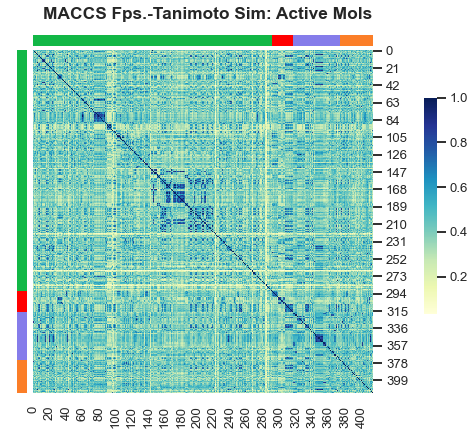

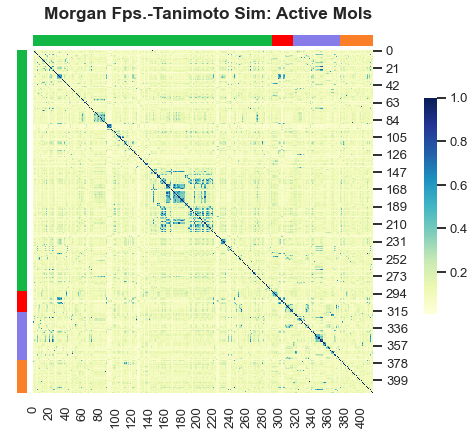

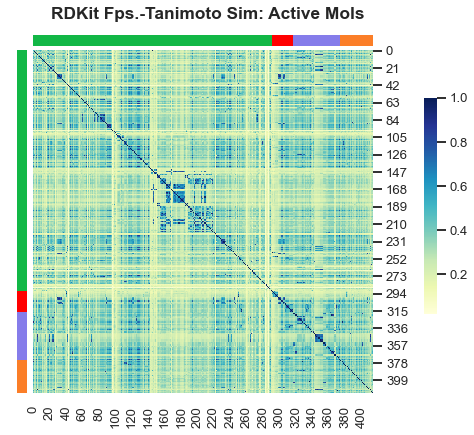

In [31]:
#*********************
# Plot the Heatmaps: Without Clustering
#*********************
clusmap_maccs = plot_cluster_map(siml_mtx_maccs, title='MACCS Fps.-Tanimoto Sim: Active Mols')
clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title='Morgan Fps.-Tanimoto Sim: Active Mols')
clusmap_rdk = plot_cluster_map(siml_mtx_rdk, title='RDKit Fps.-Tanimoto Sim: Active Mols')
plt.show()

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


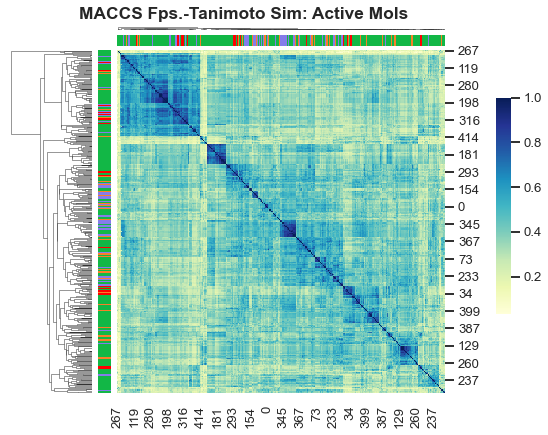

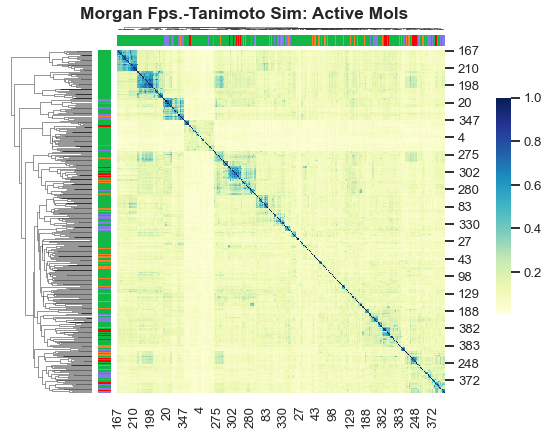

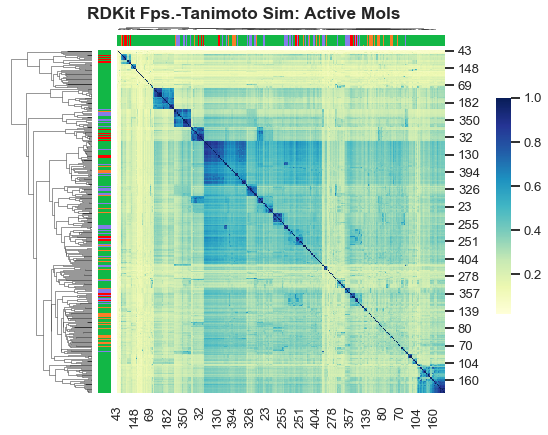

In [32]:
#*********************
# Plot the clustermaps
#*********************
clusmap_maccs = plot_cluster_map(siml_mtx_maccs, title='MACCS Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title='Morgan Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
clusmap_rdk = plot_cluster_map(siml_mtx_rdk, title='RDKit Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
plt.show()

## MDS

In [33]:
#******************************
# Compute the distance matrices
#******************************

def _get_ref_and_sup_mtx(X_set, ref_idx, sup_idx, dist='jaccard'):
    dist_mtx = get_distance_mtx(X_set, dist=dist) 
    act_dist = dist_mtx[ref_idx, :][:, ref_idx]
    sup_dist = dist_mtx[sup_idx, :][:, ref_idx]
    return act_dist, sup_dist

# Because it takes a several minutes we saved it in the following file to avoid compute it again
# File to save
pkl_file = './df_COCRYS_CSAR_DUD_DEKOIS_with_Fingerprints_MDS.obj'

if os.path.isfile(pkl_file): 
    pass 
else:
    # Compute the distance matrices
    # MACCS
    act_dist_maccs, sup_dist_maccs = _get_ref_and_sup_mtx(X_all_maccs, active_idx, inactive_idx)
    # Morgan
    act_dist_morgan, sup_dist_morgan = _get_ref_and_sup_mtx(X_all_morgan, active_idx, inactive_idx)
    # RDkit 
    act_dist_rdk, sup_dist_rdk = _get_ref_and_sup_mtx(X_all_rdk, active_idx, inactive_idx)

#### Import MDS class

In [34]:
from modules.MDS import cMDS, cMDS_proj

In [35]:
#**************
# Compute cMDS 
#**************
# Functions to copute cMDS and append to the main dataframe
def _get_ref_and_sup_mtx(X_set, ref_idx, sup_idx, dist='jaccard'):
    dist_mtx = get_distance_mtx(X_set, dist=dist) 
    ref_dist = dist_mtx[ref_idx, :][:, ref_idx]
    sup_dist = dist_mtx[sup_idx, :][:, ref_idx]
    return (ref_dist, sup_dist)

def do_mds_and_project(ref_dist, sup_dist):
    mds_obj = cMDS(ref_dist) # Do cMDS onto reference molecules
    proj_ref = mds_obj[0]
    proj_sup = cMDS_proj(mds_obj, sup_dist)
    return proj_ref, proj_sup

@run_or_load
def _add_mds_projs_to_df(filename, df_to_update, descriptors_sets,
                        ref_idx, sup_idx, dist='jaccard'):
    df = df_to_update.copy()
    for desc_name, X_set in descriptors_sets.items():
        # Compute the distance matrices
        act_dist, inact_dist = _get_ref_and_sup_mtx(X_set, ref_idx, sup_idx, dist=dist)
        # Perform the cMDS
        proj_act, proj_inact = do_mds_and_project(ref_dist=act_dist, sup_dist=inact_dist)
        # Update the dataframe
        
        # Add the columns to the dataframe
        df[desc_name + '_mds_x'] = 0
        df[desc_name + '_mds_x'].iloc[ref_idx] = proj_act[0]
        df[desc_name + '_mds_x'].iloc[sup_idx] = proj_inact.T[0]
        df[desc_name + '_mds_y'] = 0
        df[desc_name + '_mds_y'].iloc[ref_idx] = proj_act[1]
        df[desc_name + '_mds_y'].iloc[sup_idx] = proj_inact.T[1]
    return df

In [36]:
pkl_file = './df_COCRYS_CSAR_DUD_DEKOIS_with_Fingerprints_MDS.obj'

# Create two filters for active an inactive molecules
active_idx = df_all_mols[df_all_mols.Activity == 'active'].index
inactive_idx = df_all_mols[df_all_mols.Activity == 'inactive'].index

# Add the new columns over the df_dim_project DF
df_dim_mds = df_dim_project.copy()
# Dictionary with descriptors sets
descriptors_sets = {'maccs': X_all_maccs, 'morgan': X_all_morgan, 'rdk': X_all_rdk}

df_dim_mds = _add_mds_projs_to_df(filename=pkl_file, df_to_update=df_dim_mds, 
                                  descriptors_sets=descriptors_sets,
                                  ref_idx=active_idx, sup_idx=inactive_idx)

File loaded: ./df_COCRYS_CSAR_DUD_DEKOIS_with_Fingerprints_MDS.obj


In [37]:
df_dim_mds

,library,name,mol_rdk,Activity,num_rings,num_atoms,num_rot,maccs_tsne_x,maccs_tsne_y,morgan_tsne_x,morgan_tsne_y,rdk_tsne_x,rdk_tsne_y,maccs_mds_x,maccs_mds_y,morgan_mds_x,morgan_mds_y,rdk_mds_x,rdk_mds_y
0,COCRYS,STU,<rdkit.Chem.rdchem.Mol object at 0x7ffa09922070>,active,8,35,2,-17.386707,-62.706745,-41.792786,43.547764,-45.659599,0.782793,-0.050339,0.161814,0.129567,-0.111324,-0.222259,0.039234
1,COCRYS,ATP,<rdkit.Chem.rdchem.Mol object at 0x7ffa085cdf70>,active,3,31,8,-9.037222,-51.179779,-44.589218,27.270481,-7.877291,-62.804398,-0.010976,0.151860,0.065500,-0.060521,-0.142247,-0.056570
2,COCRYS,PVB,<rdkit.Chem.rdchem.Mol object at 0x7ffa085cdfb0>,active,3,18,2,47.037453,-7.306593,-49.826385,2.114326,-2.156539,-59.942863,-0.241776,-0.211612,-0.051471,-0.023561,0.084432,-0.198057
3,COCRYS,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7ffa085ce030>,active,3,22,4,-6.713167,-3.682703,-25.193827,-0.050882,-2.267751,-30.216589,-0.130155,-0.052869,-0.045903,-0.014202,0.077121,-0.074261
4,COCRYS,HMD,<rdkit.Chem.rdchem.Mol object at 0x7ffa085ce070>,active,3,19,0,7.327541,-21.726223,-59.634579,25.343990,-57.279274,4.644830,-0.028750,0.210118,0.113902,-0.148301,-0.243829,0.047992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,DEKOIS,decoy_1196,<rdkit.Chem.rdchem.Mol object at 0x7ffa08545870>,inactive,4,36,8,24.274410,-42.345493,1.722157,-56.217125,-11.466718,2.002172,-0.096377,0.212720,0.047167,0.005672,-0.041827,0.055030
3462,DEKOIS,decoy_1197,<rdkit.Chem.rdchem.Mol object at 0x7ffa085458f0>,inactive,3,30,8,28.128769,-0.018592,18.555662,-12.005270,12.004245,-30.630066,-0.047402,-0.054354,0.062717,0.029341,-0.009486,0.047984
3463,DEKOIS,decoy_1198,<rdkit.Chem.rdchem.Mol object at 0x7ffa08545970>,inactive,3,32,5,56.659191,56.086536,-11.594893,-13.141938,54.482658,-18.026035,0.217118,0.136445,0.070509,0.006144,-0.095544,0.062201
3464,DEKOIS,decoy_1199,<rdkit.Chem.rdchem.Mol object at 0x7ffa085459f0>,inactive,4,36,7,21.028332,-50.761890,4.480265,16.001957,-15.998067,-10.796708,-0.113409,0.247087,0.067944,-0.001581,-0.103906,0.048570


In [38]:
#**********
# Plotting
#**********
# Create the columndatasource
source_act = ColumnDataSource(data= df_dim_mds[df_dim_mds.Activity == 'active'].drop('mol_rdk', axis=1))
source_inact = ColumnDataSource(data= df_dim_mds[df_dim_mds.Activity == 'inactive'].drop('mol_rdk', axis=1))

# *********
# Create the figures
maccs_plot = create_fig_bokeh(desc='maccs', source_act=source_act, source_inact=source_inact,
                              col_library_map=col_library_map, title='cMDS: MACCS Keys',
                              kind_dr='mds', legend=True)
morgan_plot = create_fig_bokeh(desc='morgan', source_act=source_act, source_inact=source_inact,
                              col_library_map=col_library_map, title='cMDS: Morgan Fps.', 
                               kind_dr='mds', legend_location='top_left', legend=True)
rdk_plot = create_fig_bokeh(desc='rdk', source_act=source_act, source_inact=source_inact,
                              col_library_map=col_library_map, title='cMDS: RDKit Fps.', 
                               kind_dr='mds', legend_location='top_left', legend=True)

# Create the layout
layout = column(row(maccs_plot, morgan_plot), rdk_plot)

show(layout)

## Molecular Grid Maps
Sources:
> *Integrating the Structure-Activity Relationship Matrix Method with Molecular Grid Maps and Activity Landscape Models for Medicinal Chemistry Applications*: https://pubs.acs.org/doi/pdf/10.1021/acsomega.9b00595

> [*Visualize chemical space as a grid*](https://iwatobipen.wordpress.com/2019/08/27/visualize-chemical-space-as-a-grid-chemoinformatics-rdkit/)

> [*A shortest augmenting path algorithm for dense and sparse linear assignment problems*](https://link.springer.com/article/10.1007/BF02278710)

### Function to compute the Grid Map Embedding

In [39]:
from lapjv import lapjv
from scipy.spatial.distance import cdist

def grid_embedding_from_tsne(main_df, desc_set):
    ''' Performs a grid projection from t-SNE axes using the JV-algorithm.
    
    Parameters:
    -----------
    main_df: (pandas DataFrame)
        DataFrame with DESC_tsne_x and DESC_tsne_y columns previously computed.
        It must have "name", "Activity" and "Library" columns
    desc_set: (str)
        A string with the name of the descriptor set matching 
        the name of the x and y columns inside in main_df.
    '''
    
    # Extract in max normalization
    axes = [desc_set + '_tsne_x', desc_set + '_tsne_y']
    embeddings = main_df[axes] # Extract x and y axis
    embeddings -= embeddings.min(axis=0) # Subtract min
    embeddings /= embeddings.max(axis=0) # Divide between max - min
    # Add name, activity, and library columns
    embeddings = pd.concat([embeddings, main_df[['name', 'Activity', 'library']]], axis=1)
    
    # Grid projection
    #****************
    # Create the grid
    n_mols = embeddings.shape[0]
    grid_side_size = int(np.sqrt(n_mols))
    
    # Sample M number of molecules if the N is not a perfect square
    if np.sqrt(n_mols) % 2 != 0:
        embeddings = embeddings.sample(grid_side_size**2).sort_index()
    
    grid_space = np.linspace(0, 1, grid_side_size)
    grid = np.dstack(np.meshgrid(grid_space, grid_space)).reshape(-1, 2)
    
    # Compute euclidean distance between points given the normalized x and y axis
    cost_mat = cdist(grid, embeddings[axes], 'sqeuclidean')
    
    # Compute the JV-algorithm
    row_asses, col_asses, _ = lapjv(cost_mat)
    grid_lap = grid[col_asses]
    
    # Return a new dataframe with the new embedding coordinates
    embeddings[desc_set + '_tsne_grid_x'] = grid_lap[: , 0]
    embeddings[desc_set + '_tsne_grid_y'] = grid_lap[: , 1]
                            
    return embeddings 

In [40]:
%%time
# Funtions to run and save / load grid projections
# to avoid recomputing each time

@run_or_load
def wrapper_grid_embedding(filename, main_df, desc_set):
    df_emb_grid = grid_embedding_from_tsne(main_df, desc_set)
    return df_emb_grid

#*************************
# Perform Grid Projection
#*************************
desc_set='maccs'
grd_maccs = wrapper_grid_embedding(filename=f'./grid_tsne_plot_{desc_set}_all_mols.csv', 
                                 main_df=df_dim_project, desc_set=desc_set)

desc_set='morgan'
grd_morgan = wrapper_grid_embedding(filename=f'./grid_tsne_plot_{desc_set}_all_mols.csv', 
                                 main_df=df_dim_project, desc_set=desc_set)

desc_set='rdk'
grd_rdk = wrapper_grid_embedding(filename=f'./grid_tsne_plot_{desc_set}_all_mols.csv', 
                                 main_df=df_dim_project, desc_set=desc_set)

File loaded: ./grid_tsne_plot_maccs_all_mols.csv
File loaded: ./grid_tsne_plot_morgan_all_mols.csv
File loaded: ./grid_tsne_plot_rdk_all_mols.csv
CPU times: user 4.63 ms, sys: 11.6 ms, total: 16.3 ms
Wall time: 228 ms


In [41]:
# Auxiliar funtion to plot the embeddings coloring points by color and by library
def plot_grid_embedding(df_emb_grid, desc_set, title, color_set_1, color_set_2,
                       figsize=(16,5), col_1_title='Library', col_2_title='Activity'):
    '''Return three plots containing tsne projection and grid embedding by color
    and library. The "main_df" should contain "Activity" and "library" columns along
    with the x and y columns with the t-SNE results'''
    
    # Plot the projections
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    
    ax[0].scatter(df_emb_grid[desc_set + '_tsne_x'], df_emb_grid[desc_set + '_tsne_y'], c=color_set_1, s=5)
    ax[0].set(title='t-SNE projection', xlabel='Dim. 1 (normalized)', ylabel='Dim. 2 (normalized)')
    
    ax[1].scatter(df_emb_grid[desc_set + '_tsne_grid_x'], 
                  df_emb_grid[desc_set + '_tsne_grid_y'],  alpha=0.8, c=color_set_1, s=5)
    ax[1].get_xaxis().set_ticks([]); ax[1].get_yaxis().set_ticks([])
    ax[1].set(title='Grid Map Embedding: Color by ' + col_1_title)
    
    ax[2].scatter(df_emb_grid[desc_set + '_tsne_grid_x'], 
                  df_emb_grid[desc_set + '_tsne_grid_y'], alpha=0.8, c=color_set_2, s=5)
    ax[2].get_xaxis().set_ticks([]); ax[2].get_yaxis().set_ticks([])
    ax[2].set(title='Grid Map Embedding: Color by ' +  col_2_title)
    fig.suptitle(title, fontweight='bold', y=1)
    plt.show()

In [42]:
#********************
# Define some colors
#********************
library_colors = ['#12B746' if i == 'COCRYS' else '#FB7E28' if i == 'DEKOIS'
                  else '#CBC2F0' if i == 'DUD' else 'red' for i in grd_maccs.library]
activity_color = ['#FA5656' if i == 'active' else '#FDE1A6' for i in grd_maccs.Activity]

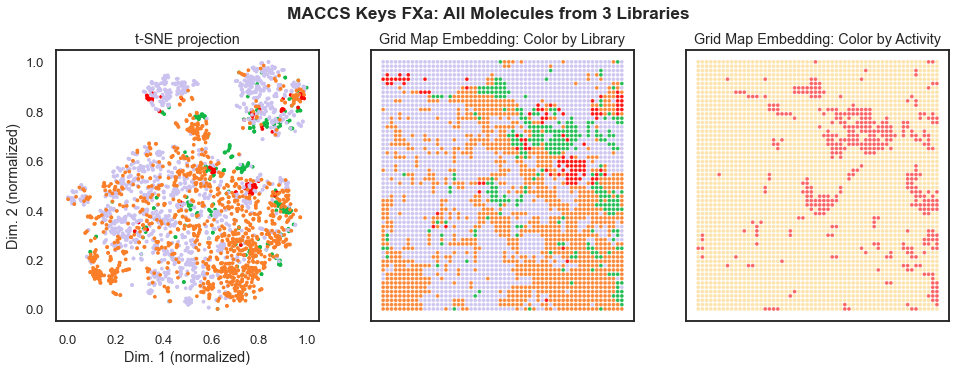

In [43]:
# Plot MACCS Keys
plot_grid_embedding(df_emb_grid=grd_maccs, desc_set='maccs',
                    title='MACCS Keys FXa: All Molecules from 3 Libraries',
                    color_set_1=library_colors, color_set_2=activity_color)